# Environment setting

In [ ]:
import glob

BASE_DIR = "gs://download.magenta.tensorflow.org/models/music_vae/colab2"

print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -q pyfluidsynth
!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib.
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library


print('Importing libraries and defining some helper functions...')
from google.colab import files
import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import numpy as np
import os
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
tf.enable_eager_execution()

# Necessary until pyfluidsynth is updated (>1.2.5).
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  print('Start Seq Reconstruction')
  play(note_sequences[0])
  print('End Seq Reconstruction')
  play(note_sequences[-1])
  print('Mean Sequence')
  play(note_sequences[num_steps // 2])
  print('Start -> End Interpolation')
  interp_seq = mm.sequences_lib.concatenate_sequences(
      note_sequences, [individual_duration] * len(note_sequences))
  play(interp_seq)
  mm.plot_sequence(interp_seq)
  return interp_seq if num_steps > 3 else note_sequences[num_steps // 2]

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)

print('Done')

# Preprocess MIDI to tfrecord

In [39]:
cd /content/drive/MyDrive/Colab Notebooks/magenta/magenta/scripts

/content/drive/MyDrive/Colab Notebooks/magenta/magenta/scripts


In [ ]:
import hashlib
import os

from note_seq import abc_parser
from note_seq import midi_io
from note_seq import musicxml_reader
import tensorflow.compat.v1 as tf

#### 1. midi를 proto로 형식의 sequence로 변환

In [ ]:
sequence = midi_io.midi_to_sequence_proto(
    tf.gfile.GFile('/content/drive/MyDrive/Colab Notebooks/magenta/magenta/scripts/INPUT_DIRECTORY/drummer1/session2/100_funk-rock_92_fill_4-4.mid', 'rb').read())

- sequence는 paly 함수를 통해 바로 재생 할 수 있다.

In [ ]:
play(sequence)

In [ ]:
sequence

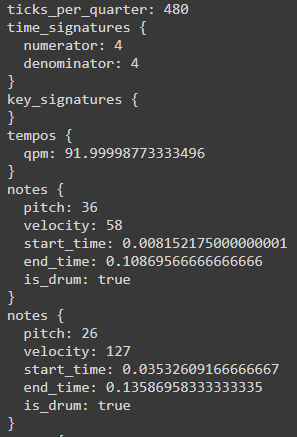

### 2. sequence를 tfrecord 형식으로 변환
- tfrecord는 tensorflow에서 사용가능한 바이너리 형식 format
- 저장 용량을 대폭 줄일 수 있고, TFRecordDataset 모듈을 통해 데이터셋을 구축할 수 있다

In [ ]:
with tf.io.TFRecordWriter('test_tfrecord') as writer:
    writer.write(sequence.SerializeToString())

### 3.  다음 script는 위 2가지 전처리를 반복, INPUT_DIRECTORY 내 모든 midi 파일을 SEQUENCES_TFRECORD로 변환.

In [ ]:
!python convert_dir_to_note_sequences.py \
  --input_dir=INPUT_DIRECTORY \
  --output_file=SEQUENCES_TFRECORD \
  --recursive

- 잘 저장 되었는지 읽어서 확인

In [ ]:
raw_dataset = tf.data.TFRecordDataset('SEQUENCES_TFRECORD')

In [ ]:
# tf.1 이라 tf.enable_eager_execution() 모드에서만 가능
for raw_record in raw_dataset.take(5):
    print(repr(raw_record))

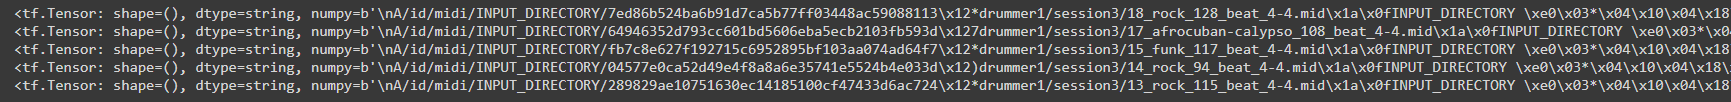

# Training
- 논문에 나온대로 50k ~ 100k 사이, 54k epoch 만큼 학습
- colab pro 환경에서 약 2시간 반 소요
- default path가 tmp/ 로 되어있어 runtime 초기화되면 ckpt가 날라간다 -> ckpt 보존을 위해 구글 드라이브로 path 조정
- hyper-parameter는 default 값 사용

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/magenta/magenta/models/music_vae

/content/drive/MyDrive/Colab Notebooks/magenta/magenta/models/music_vae


In [ ]:
!python music_vae_train.py \
--config=groovae_4bar \
--run_dir=./ckpt \
--mode=train \
--tfds_name=groove/4bar-midionly \
--chekpoint_to_keep 50

# Sampling 
- 학습된 모델을 load 하고, 랜덤 가우시안 벡터를 디코더에 통과시켜 sample 생성
- 4마디 샘플을 생성하므로, length = 64비트(16 x 4) 
- 생성된 샘플은 generated_sample/ 에 저장

In [ ]:
# load trained model
drums_models = {}
drums_config = configs.CONFIG_MAP['groovae_4bar']
drums_models['groovae_4bar'] = TrainedModel(drums_config, batch_size=4, checkpoint_dir_or_path='./ckpt/train/model.ckpt-54120')

In [34]:
# sampling 4 bars
drums_sample_model = "groovae_4bar"
temperature = 0.5
drums_samples = drums_models[drums_sample_model].sample(n=4, length=64, temperature=temperature)
for ns in drums_samples:
  play(ns)

In [ ]:
# 생성된 샘플 data sequence 
drums_samples[0]

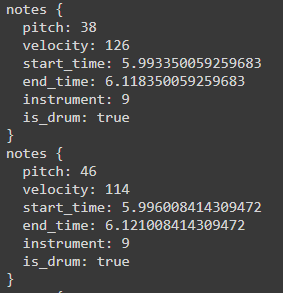